### Overview
This tutorial shows you the primary functions and basic use of AutoClass Module. Please cite our paper when using this open-source module or the AutoClass method:
<br>
<br>
[Li H, Brouwer C, Luo W. A Universal Deep Neural Network for In-Depth Cleaning of Single-Cell RNA-Seq Data. Submitted, 2020](https://doi.org/10.1101/2020.12.04.412247) 
<br>
<br>
Please go through this tutorial and other documentation of this module before actual use.

### Getting started

Download the [AutoClass](https://github.com/datapplab/AutoClass/tree/master/AutoClass) module, and change directory to the AutoClass folder, and unzip the demo data folder.

In [1]:
#code under Linux, modify based on your system and local directory
%cd /path/to/your/downloaded/AutoClass
!unzip datasets/Dataset1.zip

#### Import relevent AutoClass functions 

In [2]:
from AutoClass.AutoClass import AutoClassImpute, take_norm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Read in demo data, including raw data, true data and cell type info.
Demo dataset can be found in [dataset](https://github.com/datapplab/AutoClass/tree/master/datasets).

In [4]:
expr = pd.read_csv('Dataset1/counts.csv',index_col=0)
expr_true = pd.read_csv('Dataset1/truecounts.csv',index_col=0)
cellinfo = pd.read_csv('Dataset1/cellinfo.csv',index_col=0)

In [5]:
X = expr.values #Splash generated scRNA-seq data with dropout
X_true = expr_true.values #Splash generated scRNA-seq data without dropout (ground truth)
Y = cellinfo['Group'].values #cell type label
unique_class = np.unique(Y)
celltypes = Y
K = len(unique_class)
ncell,ngene = X.shape
print('{} genes, {} cells in {} groups'.format(ngene,ncell,K))

938 genes, 500 cells in 6 groups


In [6]:
#library size normalization followed by a log2 transformation with pseudo count 1
X_norm = take_norm(X)
X_true_norm = take_norm(X_true)

#### Set random seeds as to reproduce the results in the notebook

In [7]:
import random
import os
sd=1
os.environ['PYTHONHASHSEED']=str(sd)
random.seed(sd)
np.random.seed(sd)
#tf.random.set_seed(sd)

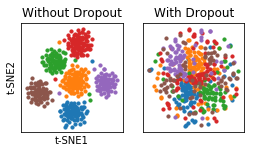

In [8]:
pca_raw = PCA(n_components=50,random_state=1).fit_transform(X_norm)
tsne_raw = TSNE(n_components=2,random_state=1).fit_transform(pca_raw)
pca_true = PCA(n_components=50,random_state=1).fit_transform(X_true_norm)
tsne_true = TSNE(n_components=2,random_state=1).fit_transform(pca_true)

fig = plt.figure(figsize=(4,2))
fig.add_subplot(121)
for i in range(K):
    plt.scatter(tsne_true[Y==unique_class[i],0],
                tsne_true[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Without Dropout')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
    
fig.add_subplot(122)
for i in range(K):
    plt.scatter(tsne_raw[Y==unique_class[i],0],
                tsne_raw[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('With Dropout')
plt.xticks([],[])
plt.yticks([],[])
plt.show()

### Imputation by AutoClass with default setting
The input to `AutoClassImpute` is a matrix of gene expression counts with cells along the rows and genes along the columns.

In [9]:
res = AutoClassImpute(X)

500 cells and 938 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 26.289113759994507


`res` is a dictionary contains three items:

- `res['imp']` gives the normailzed AutoClass imputation result.
- `res['model']` gives the AutoClass network informaton.
- `res['loss_history']` gives the loss information. 

#### Visualize the imputed result 

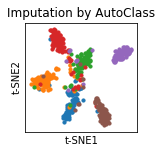

In [10]:
imp = res['imp'] #imputation result (already normalized, ready for analysis)
PCA_imp = PCA(n_components=50,random_state=1).fit_transform(imp)
tsne_imp = TSNE(n_components=2,random_state=1).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

#### Print model information

In [11]:
print(res['model'][0].summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 938)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          120192      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           dense[0][0]                      
__________________________________________________________________________________________________
classification (Dense)          (None, 8)            1032        dropout[0][0]                    
______________________________________________________________________________________________

### Imputation by AutoClass with other parameter settings

- By default, `AutoClassImpute` takes in an unnormalized count matrix and performs library size normalization and log transformation. If your data is already normalized or normalization is not needed, you can set `cellwise_norm=False`, `log1p=False`. E.g.,

  `res = AutoClassImpute(X_norm,cellwise_norm=False,log1p=False)`


- AutoClass use K-means in the pre-clustering step to obtain virtual cluster labels, the default cluster numbers are 8,9,10. The final imputation result is the average results over different pre-clustering settings. Other pre-cluster numbers can be used by setting `num_cluster=[k1,k2,...]` or `num_cluster=k`. E.g.,

 Use a list of integers: `res = AutoClassImpute(X,num_cluster = [5,6,7])`
 
 Or use a single integer: `res = AutoClassImpute(X,num_cluster = 6)`


500 cells and 938 genes
number of clusters in pre-clustering:[5, 6, 7]
n_cluster = 5...
n_cluster = 6...
n_cluster = 7...
escape time is: 19.51799988746643


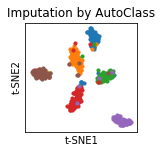

In [12]:
res = AutoClassImpute(X,num_cluster = 6)
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50,random_state=1).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2,random_state=1).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

- AutoClass loss is a weighted sum of classification loss and reconstruction loss. The weights of these two losses are w and 1-w. Default w is 0.9. Users can change the value of `classifier_weight` to change the classification loss weight. To remove the classifier component, set `classifier_weight=0`. I.e.,
  
  `res = AutoClassImpute(X,classifier_weight=0) `


500 cells and 938 genes
no classifier layer
run the model 3 times and average the final imputation results
n_run = 1...
n_run = 2...
n_run = 3...
escape time is: 23.90649151802063


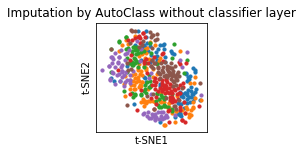

In [13]:
res = AutoClassImpute(X,classifier_weight=0)
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50,random_state=1).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2,random_state=1).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass without classifier layer')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

- If cell type informatin is provided, it can be used in the AutoClass model directly by passing it to `truelabel` and skip the pre-clustering step. I.e.,

  `res = AutoClassImpute(X,truelabel=celltypes)`

In [14]:
res = AutoClassImpute(X,truelabel=celltypes)
imp_auto = res['imp']

500 cells and 938 genes
use provided celltype information
run the model 3 times and average the final imputation results
n_run = 1...
n_run = 2...
n_run = 3...
escape time is: 30.335268259048462


- By default, dropout of neurons is used to prevent overfitting. Dropout is applied to the bottleneck layer (except output layers), and dropout weight is 0.1. Users can use other dropout weight by changing the value of `dropout_rate`. E.g.,

  `res = AutoClassImpute(X,dropout_rate=0.3)`


- By default, the autoencoder component in AutoClass contains one hidden layer, i.e., the bottleneck layer, and the default size (number of neurons) is 128. Users can specify other **encoder layer sizes** in `encoder_layer_size`. E.g., autoencoder component with five hidden layers, layer sizes [256,128,32,128,256]:

  `res = AutoClassImpute(X,encoder_layer_size=[256,128,32])`

   Or, autoencoder component with one hidden layer, layer size 16:
   
  `res = AutoClassImpute(X,encoder_layer_size=[16])`


  Tips: if bottleneck layer is too small (e.g., 16), it is better not to use dropout regulerization, and a lower `classifier_weight` value is      recommended.

500 cells and 938 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 33.64042639732361


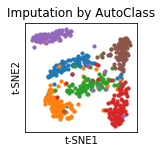

In [16]:
res = AutoClassImpute(X,encoder_layer_size=[16],classifier_weight=0.1,
                      dropout_rate=0)
imp_auto = res['imp']
 
PCA_imp = PCA(n_components=50,random_state=1).fit_transform(imp_auto)
tsne_imp = TSNE(n_components=2,random_state=1).fit_transform(PCA_imp)
fig = plt.figure(figsize=(2,2))
for i in range(K):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

- AutoClass uses `Keras.Adam` optimizer with default learning rate 0.001. Learning rate is multiplied by 0.1 if validation loss does not improve for `lr=15` epochs. The training stops if there is no improvement for `es=30` epochs. The learning rate adjustment epochs and early stopping eopchs can be changed by changing the value of `lr` and `es`. E.g.,

   `res = AutoClassImpute(X,lr=10,es=20)`